In [1]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from multiprocessing import Queue
from multiprocessing import Process
from Bio.Seq import Seq
from Bio import SeqIO
from multiprocessing import Pool, freeze_support
import math

/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

# Info about paths

In [2]:
cell_type = 'K562'
mod_id = 'GSM4041595_K562_rep2.hg38'
k = 4
window = 600

In [3]:
cont_data_path = f'/home/pitikovegor/CourseWork/genomes/reds_experiments/{cell_type}/all_parsed/'
sequence_path = '/home/pitikovegor/CourseWork/genomes/chr_sequence'
window = 500

chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

# Count kmers and make sets

In [4]:
params = {'pval_trash_good': 0.05,
          'pval_trash_bad': 0.1,
          'rna_count_trash':  900,
          'cont_count_trash': 0,
          'zscore_trash_good': 0,
          'zscore_trash_bad_max': 1,
          'zscore_trash_bad_min': -1,
          'clus_count_rna' : 10,
          'clus_count_dna' : 10,
          'class_trash_good': [''],
          'class_trash_bad': ['protein_coding']}

In [5]:
#extract k-mers
def seq_cutter(sequence, position, chain, window = 500):
    if chain=='+':
        return sequence[max(0, position[0]+1-window) : min(position[1]+1+window, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-window) : min(position[1]+1+window, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq
    
#def k_mer_counter (k, sequence):
 #   k_mers_count = max(len(sequence) - k + 1, 1)
  #  sequence = [sequence]
   # k_mers = Profile.from_sequences(sequence, k).counts
  #  k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
 #   return k_mers


def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    all_kmers_freqs = []
    for i in range(k):
        k_mer = Profile.from_sequences(list(sequence), i).counts
        k_mer_count = max(len(sequence) - i + 1, 1)
        k_mer = np.multiply(k_mer, np.array([1/k_mer_count]*len(k_mer)))
        all_kmers_freqs.append(k_mer)
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    for i in range(len(all_kmers_freqs)):
        k_count = 4**(i+1)
        for j in range(len(k_mers)//k_count):
            k_mers[j*k_count:(j+1)*k_count]
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table, window = 500):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3], window = window)
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 4:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(5+4**k)))
            

In [6]:
def make_sets (contact_data_table, params):
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    contacts['class'] = 0
    conditions = [
        #(contacts['pval'] <= params['pval_trash_good']) &
        (contacts['rnaseq_count'] >= params['rna_count_trash']) &
        (contacts['zscore'] >= params['zscore_trash_good']) &
        (contacts['contacts_count'] >= params['cont_count_trash']) &
        (contacts['rna_chr']!= contacts['dna_chr']) &
        (contacts['clus_count_rna'] >= params['clus_count_rna']) &
        (contacts['clus_count_dna'] >= params['clus_count_dna'])
     ]
    values = [1]
    contacts['class'] = pd.Series(np.select(conditions, values))
    return contacts

In [7]:
def all_tables(chr_seq, contact_data_table, params, k, window = 500):
    chr_cont = make_sets(contact_data_table, params)
    print('%s is %s length' % (contact_data_table.split('/')[-1], len(chr_cont['class'])))
    true_positive = chr_cont[(chr_cont['class']==1)]
    true_positive = true_positive.sample(n = min(len(true_positive['class']), 100000))
    true_negative = chr_cont[#(chr_cont['pval']>=params['pval_trash_bad']) & 
                             (chr_cont['dna_chr']!=chr_cont['rna_chr'])]
    print('%s negative after pval %s length' % (contact_data_table.split('/')[-1], len(true_negative['class'])))
    true_negative = true_negative[(true_negative['gene_type'] == 'protein_coding') & 
                                  (true_negative['clus_count_dna'] < 3)]
    true_negative = true_negative.sample(n = min(len(true_negative['class']), len(true_positive['class'])*5))
    del chr_cont
    print('Start k-mers %s' % contact_data_table.split("/")[-1])
    kmers_positive = sequence_process_rna(chr_seq, k, true_positive[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'class']], window = window)
    kmers_negative = sequence_process_rna(chr_seq, k, true_negative[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'class']], window = window)
    print('From %s %s positive %s negative' % (contact_data_table.split("/")[-1], len(true_positive['class']), len(true_negative['class'])))
    return true_positive, true_negative, kmers_positive, kmers_negative  

In [8]:
all_proc = Pool(processes = 24)
#all_data.close()
all_data = all_proc.starmap(all_tables, [('%s/%s.fna' % (sequence_path, i), f'{cont_data_path}/{i}_all_table.tsv', params, k, window) for i in chr_names])
all_proc.close()
all_proc.join()

chrY_all_table.tsv is 127 length
chrY_all_table.tsv negative after pval 127 length
Start k-mers chrY_all_table.tsv
From chrY_all_table.tsv 0 positive 0 negative
chr20_all_table.tsv is 586255 length
chr20_all_table.tsv negative after pval 539390 length
Start k-mers chr20_all_table.tsv
chr13_all_table.tsv is 859896 length
chr13_all_table.tsv negative after pval 744561 length
Start k-mers chr13_all_table.tsv
chr18_all_table.tsv is 747458 length
chr18_all_table.tsv negative after pval 653191 length
Start k-mers chr18_all_table.tsv
chr21_all_table.tsv is 767169 length
chr17_all_table.tsv is 1212269 length
chr21_all_table.tsv negative after pval 718237 length
chr17_all_table.tsv negative after pval 1121865 length
chr14_all_table.tsv is 1373433 length
chr22_all_table.tsv is 829711 length
Start k-mers chr21_all_table.tsv
chr15_all_table.tsv is 857678 length
chr22_all_table.tsv negative after pval 783959 length
Start k-mers chr17_all_table.tsv
chr15_all_table.tsv negative after pval 768162 leng

In [9]:
all_contacts = pd.concat([i[0] for i in all_data] + [i[1] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[2] for i in all_data] + [i[3] for i in all_data], ignore_index = True)

In [10]:
all_kmers

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,259,260
0,D00795:30:CA2UTANXX:1:1310:18334:18583,9539350,9541431,+,1,0.0136452,0.00454841,0.00682261,0.00844704,0.00682261,...,0.000324886,0.00779727,0.00454841,0.00389864,0.00844704,0.00974659,0.00454841,0.00649773,0.00844704,0.00747238
1,M01460:89:000000000-AJJ2J:1:1117:8781:19203,74217251,74219273,-,1,0.0152368,0.00596224,0.005631,0.00828089,0.005631,...,0.000662471,0.00529977,0.00728718,0.00662471,0.00397483,0.00794965,0.00662471,0.00629347,0.00828089,0.00794965
2,D00795:30:CA2UTANXX:1:1207:2249:88194,26722780,26724810,+,1,0.0066072,0.00231252,0.0066072,0.0066072,0.00528576,...,0.00033036,0.00693756,0.0049554,0.00429468,0.00594648,0.00561612,0.011893,0.00759828,0.00925008,0.0181698
3,D00795:28:C99BVACXX:7:1108:19414:11801,26723792,26725835,+,1,0.00789474,0.00361842,0.00625,0.00789474,0.00690789,...,0.000328947,0.00921053,0.00756579,0.00460526,0.00526316,0.00756579,0.0148026,0.0101974,0.0105263,0.0266447
4,D00795:30:CA2UTANXX:5:2203:19145:4481,74244493,74246513,-,1,0.0129267,0.00364601,0.00331455,0.00994365,0.00729201,...,0.000994365,0.0116009,0.00530328,0.00629765,0.0029831,0.0106066,0.0172357,0.0135897,0.0125953,0.0417633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171341,D00795:30:CA2UTANXX:1:1307:11995:99947,24621019,24623083,+,0,0.0192747,0.00326691,0.00424698,0.00392029,0.00522705,...,0.000326691,0.00261352,0.00261352,0.00261352,0.00392029,0.00228683,0.000653381,0.00130676,0.00294022,0.000980072
2171342,D00795:30:CA2UTANXX:1:2202:3479:33822,29288803,29290860,+,0,0.0127701,0.00491159,0.00982318,0.00884086,0.00556647,...,0.000982318,0.00589391,0.00687623,0.00392927,0.00589391,0.00982318,0.0117878,0.00884086,0.0108055,0.0173543
2171343,D00795:30:CA2UTANXX:5:1312:12454:38826,20539774,20541851,+,0,0.0240729,0.00553025,0.00553025,0.0156148,0.00683149,...,0.000650618,0.00422902,0.00585556,0.0035784,0.00585556,0.00585556,0.00748211,0.00585556,0.00845804,0.0208198
2171344,D00795:30:CA2UTANXX:1:2303:11148:74521,18125413,18127509,+,0,0.0126091,0.00226317,0.00484966,0.00484966,0.00258649,...,0,0.00581959,0.00452635,0.00387973,0.00549628,0.00581959,0.00484966,0.00452635,0.00840608,0.0210152


In [11]:
all_contacts

,contacts_count,rnaseq_count,cont,rnaseq,chP,zscore,pval,gene_name,ensg,rna_chr,...,gene_bgn,gene_end,gene_type,ac,clus_count_rna,dna_chr,dna_bgn,dna_end,clus_count_dna,class
0,19840,2879,0.000525,0.000067,2.054347,1.605305,0.108427,TBL1X,ENSG00000101849.17,chrX,...,9463295,9741037,protein_coding,ENSG00000101849.17,18245,chr13,91126141,91128164,11,1
1,24154,3527,0.000640,0.000082,2.048147,1.599703,0.109665,FTX,ENSG00000230590.11,chrX,...,73940435,74293574,lncRNA,ENSG00000230590.11,24504,chr13,91198941,91200965,16,1
2,16510,4787,0.000437,0.000112,1.362301,0.979939,0.327116,VENTXP1,ENSG00000259849.2,chrX,...,26557675,26881029,transcribed_processed_pseudogene,ENSG00000259849.2,15956,chr13,91010016,91012039,13,1
3,16510,4787,0.000437,0.000112,1.362301,0.979939,0.327116,VENTXP1,ENSG00000259849.2,chrX,...,26557675,26881029,transcribed_processed_pseudogene,ENSG00000259849.2,15956,chr22,23231022,23233046,11,1
4,24154,3527,0.000640,0.000082,2.048147,1.599703,0.109665,FTX,ENSG00000230590.11,chrX,...,73940435,74293574,lncRNA,ENSG00000230590.11,24504,chr13,91273146,91275170,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171341,104,86,0.000003,0.000002,0.312439,0.031233,0.975084,AP000356.5,ENSG00000286070.2,chr22,...,24556007,24628987,protein_coding,ENSG00000286070.2,1494,chr8,119659816,119661839,1,0
2171342,9128,9830,0.000242,0.000230,0.050303,-0.205647,0.837067,EWSR1,ENSG00000182944.18,chr22,...,29268009,29300525,protein_coding,ENSG00000182944.18,8820,chr1,236947857,236949880,1,0
2171343,16800,5075,0.000445,0.000119,1.321302,0.942890,0.345737,MED15,ENSG00000099917.17,chr22,...,20495913,20587632,protein_coding,ENSG00000099917.17,15380,chr5,140017779,140019802,1,0
2171344,2638,2068,0.000070,0.000048,0.367722,0.081188,0.935292,PEX26,ENSG00000215193.13,chr22,...,18077920,18131138,protein_coding,ENSG00000215193.13,2460,chr5,61976111,61978134,1,0


# Training

In [12]:
good_contacts = all_kmers[all_kmers[4]==1]
good_contacts = good_contacts.sample(n = min(len(good_contacts[0]), 500000))
bad_contacts = all_kmers[all_kmers[4]==0]
bad_contacts = bad_contacts.sample(n = min(len(good_contacts[0])*10, len(bad_contacts[0])))
all_set_contacts = good_contacts.append(bad_contacts, ignore_index = True)
del good_contacts
del bad_contacts
all_set_contacts = all_set_contacts.to_numpy()

In [13]:
data_train, data_test, label_train, label_test = train_test_split(all_set_contacts[:, 5:], all_set_contacts[:, 4], test_size=0.2, random_state=42)

In [14]:
dtrain = xgb.DMatrix(data_train, label=label_train)
dtest = xgb.DMatrix(data_test, label=label_test)

In [17]:
param = {
    'max_depth': 1000,
    'eta': 0.3, 
    'silent': 4, 
    'objective': 'multi:softprob',
    'num_class': 2,
    'nthread' : 10,
    'num_parallel_tree': 4,
    'booster': 'gbtree'
    }
num_boost_round = 50

In [21]:
bst = xgb.XGBClassifier(param)
bst.fit(dtrain, num_boost_round=num_boost_round)

trees = [s for s in bst]
assert len(trees) == num_boost_round

TypeError: fit() got an unexpected keyword argument 'num_boost_round'

In [20]:
?xgb.XGBClassifier

In [ ]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
q = 30
name = 'xgb_clusters_%s_%s_%s' % (current_time, k, mod_id)
bst.save_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s' % name)
bst.dump_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s_dump' % name, '/Users/pitikov_egor/Documents/CourseWork/genomes/models/features_%s' % name)
q+=1

In [ ]:
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
precision_score(list(label_test), best_preds)

In [ ]:
fpr, tpr, thresholds = roc_curve(list(label_test), list(preds[:, 1]))

In [ ]:
plt.figure(1, figsize=(30, 30))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='epoch=%s, xgb'%(num_boost_round))
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve xgb 4-mers', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.savefig('/Users/pitikov_egor/Documents/CourseWork/genomes/pictures/Models/%s_ROC.png' % name)
plt.show()

In [ ]:
del all_set_contacts

# Open and check

In [82]:
modelname = 'xgb_trans_15:17:46_GSM4041595_K562_rep2.hg38'

In [83]:
bst = xgb.Booster({'nthread': 10})
bst.load_model('/Users/pitikov_egor/Documents/CourseWork/genomes/models/%s.model' % modelname) 

In [84]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
cont_data_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)
sequence_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/chr_sequence'

In [85]:
def make_test_sets (contact_data_table, redc_table):
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_table(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner')
    del redc
    #contacts = contacts[contacts['rna_chr']!=contacts['dna_chr']]
    contacts['class'] = 0
    return contacts

In [86]:
def all_test_tables(chr_seq, contact_data_table, redc_table, k):
    chr_cont = make_test_sets(contact_data_table,  redc_table)
    kmer = sequence_process_rna(chr_seq, k, chr_cont[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'gene_type']])
    return chr_cont, kmer

In [87]:
all_proc_test = Pool(processes = 24)
all_data = all_proc_test.starmap(all_test_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), k) for i in chr_names])
all_proc_test.close()
all_proc_test.join()

In [88]:
all_contacts = pd.concat([i[0] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[1] for i in all_data], ignore_index = True)

In [89]:
all_kmers = all_kmers.to_numpy()
full_kmers = xgb.DMatrix(all_kmers[:, 5:])
preds = bst.predict(full_kmers)
best_preds = np.asarray([np.argmax(line) for line in preds])


In [90]:
best_preds
preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
gene_types = list(set(all_kmers[:, 4]))

In [91]:
means = {}
for i in gene_types:
    spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
    nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
    print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
    means[i] = [nonspec, spec]

miRNA have 0 specific and 54 nonspecific contacts
TEC have 0 specific and 297 nonspecific contacts
snRNA have 812 specific and 4480 nonspecific contacts
transcribed_unitary_pseudogene have 2 specific and 1022 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
transcribed_processed_pseudogene have 0 specific and 8470 nonspecific contacts
processed_pseudogene have 0 specific and 516 nonspecific contacts
transcribed_unprocessed_pseudogene have 0 specific and 5134 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
unprocessed_pseudogene have 0 specific and 455 nonspecific contacts
unitary_pseudogene have 0 specific and 5 nonspecific contacts
snoRNA have 0 specific and 4915 nonspecific contacts
IG_V_gene have 0 specific and 3 nonspecific contacts
lncRNA have 2373 specific and 205347 nonspecific contacts
protein_coding have 2790 specific and 1016469 nonspecific contacts
scaRNA have 0

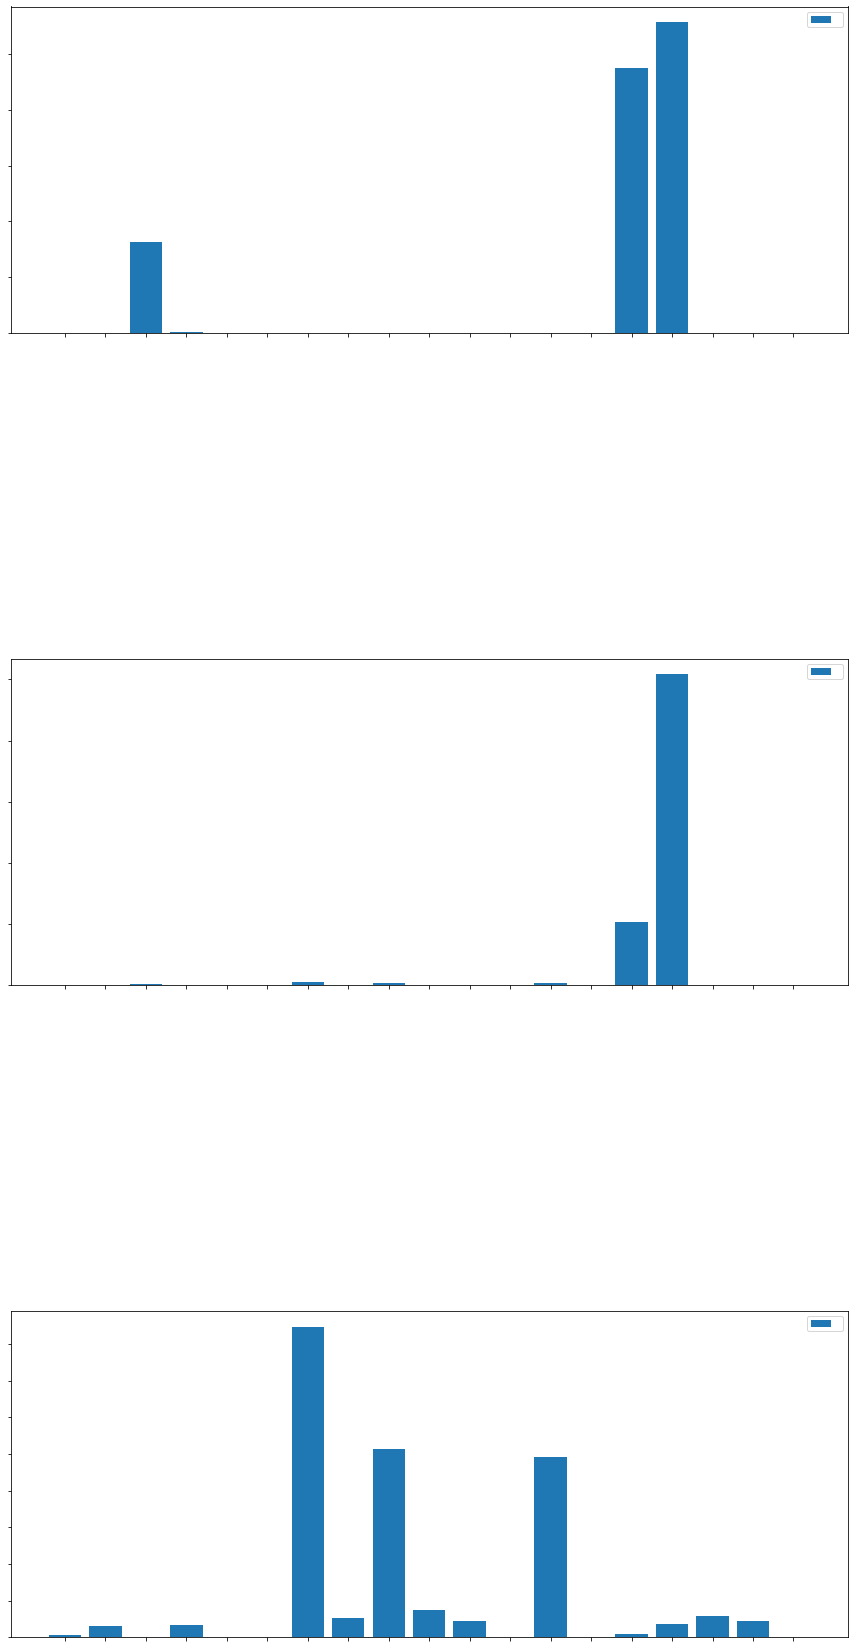

In [92]:
plt.rcParams['axes.titlesize'] = 8
fig = plt.figure(1, figsize=(15, 30))
gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, :])
spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], label='specific')
ax0.set_ylabel('Number')
ax0.set_title('Specific by classes', fontsize=20)
ax0.set_xticks(np.arange(len(means.keys()))) 
ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1, :])
nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], label='nonspecific')
ax1.set_ylabel('Number')
ax1.set_title('Nonspecific by classes', fontsize=20)
ax1.set_xticks(np.arange(len(means.keys())))
ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax1.legend()
ax2 = fig.add_subplot(gs[2, :])
nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], label='nonspecific/specific')
ax2.set_ylabel('Number')
ax2.set_title('Nonspecific/specific by classes', fontsize=20)
ax2.set_xticks(np.arange(len(means.keys())))
ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax2.legend()
plt.subplots_adjust(wspace=2, hspace=1)
plt.savefig('/Users/pitikov_egor/Documents/CourseWork/genomes/pictures/Models/%s_coninfo.png' % modelname)
plt.show()



# return genes with specefic and nonespecific contacts

In [109]:
preds_to_type = pd.DataFrame(preds_to_type)

In [110]:
preds_to_type = pd.merge(left=preds_to_type, right=all_contacts[['id', 'gene', 'gene_ac']], left_on=2, right_on='id', how ='inner')

In [111]:
preds_to_type

,0,1,2,id_x,gene_x,gene_ac_x,id_y,gene_y,gene_ac_y
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...,...,...,...
1483489,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1483490,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1483491,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1483492,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [112]:
preds_to_type = preds_to_type.drop_duplicates()
preds_to_type

,0,1,2,id_x,gene_x,gene_ac_x,id_y,gene_y,gene_ac_y
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...,...,...,...
1483489,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1483490,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1483491,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1483492,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [113]:
len(set(preds_to_type[2]))
#There are contacts mapped on 2 and more genes - and I don't know, what's correct gene...

1194791

In [121]:
preds_to_type['gene'] = preds_to_type['gene_x']
preds_to_type['gene_ac'] = preds_to_type['gene_ac_x']

In [122]:
gene_preds = preds_to_type[['gene', 'gene_ac', 0, 1,]]
gene_preds = gene_preds.rename(columns={0: 'class', 1: 'type'})
gene_preds = gene_preds.groupby(gene_preds.columns.tolist()[::-1]).size()
gene_preds = pd.DataFrame(gene_preds)
gene_preds.reset_index(inplace=True)
gene_preds = gene_preds.rename(columns={0: 'number'})

In [123]:
gene_preds['positive'] = 0
gene_preds['negative'] = 0
gene_preds.loc[gene_preds[gene_preds['class']==1].index, 'positive'] = gene_preds[gene_preds['class']==1].loc[:, 'number']
gene_preds.loc[gene_preds[gene_preds['class']==0].index, 'negative'] = gene_preds[gene_preds['class']==0].loc[:, 'number']
gene_preds.pop('class').drop_duplicates()

0       0
3463    1
Name: class, dtype: int64

In [124]:
gene_preds

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,6,0,6
1,IG_V_gene,ENSG00000286129.1,AC245060.7,6,0,6
2,TEC,ENSG00000048405.10,ZNF800,112,0,112
3,TEC,ENSG00000051825.15,MPHOSPH9,4,0,4
4,TEC,ENSG00000070366.14,SMG6,2,0,2
...,...,...,...,...,...,...
16401,unprocessed_pseudogene,ENSG00000283131.1,MTND2P41,1,0,1
16402,unprocessed_pseudogene,ENSG00000283491.1,AC017104.4,7,0,7
16403,unprocessed_pseudogene,ENSG00000284707.2,AC079781.5,8,0,8
16404,unprocessed_pseudogene,ENSG00000285725.1,AC004967.2,6,0,6


In [125]:
gene_preds = gene_preds.sort_values(by = ['positive'])

In [126]:
gene_preds = gene_preds.reset_index(drop = True)

In [127]:
gene_preds.drop_duplicates()

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,6,0,6
1,protein_coding,ENSG00000163374.19,YY1AP1,111,0,111
2,protein_coding,ENSG00000163376.11,KBTBD8,24,0,24
3,protein_coding,ENSG00000163378.14,EOGT,24,0,24
4,protein_coding,ENSG00000163382.12,NAXE,4,0,4
...,...,...,...,...,...,...
16401,snRNA,ENSG00000133316.15,WDR74,1624,1624,0
16402,snRNA,ENSG00000222328.1,RNU2-2P,1624,1624,0
16403,protein_coding,ENSG00000133316.15,WDR74,1624,1624,0
16404,protein_coding,ENSG00000222328.1,RNU2-2P,1624,1624,0


In [128]:
normalised = pd.read_table('/Users/pitikov_egor/Documents/CourseWork/genomes/normalisation_data/K562.pvalue.tab.txt', sep='\t')

In [129]:
all_info = pd.merge(left=normalised, right=gene_preds, left_on='gene_name', right_on='gene', how ='inner')

In [130]:
all_info

,gene_name_un,gene_chr,gene_start,gene_end,gene_strand,ensg,gene_type,gene_name,contacts_count,rnaseq_count,...,rnaseq,chP,zscore,pval,type,gene_ac,gene,number,positive,negative
0,A1BG-AS1,chr19,58347718,58355455,+,ENSG00000268895.6,lncRNA,A1BG-AS1,122,122,...,2.876159e-06,0.124387,-0.138701,0.889687,lncRNA,ENSG00000268895.6,A1BG-AS1,9,0,9
1,A2ML1,chr12,8822621,8887001,+,ENSG00000166535.20,protein_coding,A2ML1,4,4,...,1.169170e-07,0.124387,-0.138701,0.889687,protein_coding,ENSG00000166535.20,A2ML1,1,0,1
2,A3GALT2,chr1,33306766,33321098,-,ENSG00000184389.9,protein_coding,A3GALT2,36,8,...,2.104506e-07,1.538081,1.138781,0.254794,protein_coding,ENSG00000184389.9,A3GALT2,1,0,1
3,AAAS,chr12,53307456,53324864,-,ENSG00000094914.14,protein_coding,AAAS,396,1380,...,3.229248e-05,-1.122240,-1.265213,0.205795,protein_coding,ENSG00000094914.14,AAAS,12,0,12
4,AACS,chr12,125065434,125143333,+,ENSG00000081760.17,protein_coding,AACS,2520,1045,...,2.445904e-05,1.004069,0.656223,0.511681,protein_coding,ENSG00000081760.17,AACS,108,0,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,ZYG11A,chr1,52842511,52894998,+,ENSG00000203995.10,protein_coding,ZYG11A,7511,2400,...,5.614355e-05,1.265004,0.892016,0.372384,protein_coding,ENSG00000203995.10,ZYG11A,261,0,261
16468,ZYG11B,chr1,52726453,52827336,+,ENSG00000162378.13,protein_coding,ZYG11B,2497,2130,...,4.983003e-05,0.283286,0.004888,0.996100,protein_coding,ENSG00000162378.13,ZYG11B,85,0,85
16469,ZYX,chr7,143381295,143391111,+,ENSG00000159840.16,protein_coding,ZYX,902,314,...,7.365772e-06,1.177537,0.812977,0.416231,protein_coding,ENSG00000159840.16,ZYX,25,0,25
16470,ZZEF1,chr17,4004445,4143030,-,ENSG00000074755.15,protein_coding,ZZEF1,4553,3343,...,7.819410e-05,0.433225,0.140381,0.888359,protein_coding,ENSG00000074755.15,ZZEF1,125,0,125


In [131]:
all_info['con_per_mol'] = all_info.loc[:, 'contacts_count']/all_info.loc[:, 'rnaseq_count']

In [132]:
all_info

,gene_name_un,gene_chr,gene_start,gene_end,gene_strand,ensg,gene_type,gene_name,contacts_count,rnaseq_count,...,chP,zscore,pval,type,gene_ac,gene,number,positive,negative,con_per_mol
0,A1BG-AS1,chr19,58347718,58355455,+,ENSG00000268895.6,lncRNA,A1BG-AS1,122,122,...,0.124387,-0.138701,0.889687,lncRNA,ENSG00000268895.6,A1BG-AS1,9,0,9,1.000000
1,A2ML1,chr12,8822621,8887001,+,ENSG00000166535.20,protein_coding,A2ML1,4,4,...,0.124387,-0.138701,0.889687,protein_coding,ENSG00000166535.20,A2ML1,1,0,1,1.000000
2,A3GALT2,chr1,33306766,33321098,-,ENSG00000184389.9,protein_coding,A3GALT2,36,8,...,1.538081,1.138781,0.254794,protein_coding,ENSG00000184389.9,A3GALT2,1,0,1,4.500000
3,AAAS,chr12,53307456,53324864,-,ENSG00000094914.14,protein_coding,AAAS,396,1380,...,-1.122240,-1.265213,0.205795,protein_coding,ENSG00000094914.14,AAAS,12,0,12,0.286957
4,AACS,chr12,125065434,125143333,+,ENSG00000081760.17,protein_coding,AACS,2520,1045,...,1.004069,0.656223,0.511681,protein_coding,ENSG00000081760.17,AACS,108,0,108,2.411483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,ZYG11A,chr1,52842511,52894998,+,ENSG00000203995.10,protein_coding,ZYG11A,7511,2400,...,1.265004,0.892016,0.372384,protein_coding,ENSG00000203995.10,ZYG11A,261,0,261,3.129583
16468,ZYG11B,chr1,52726453,52827336,+,ENSG00000162378.13,protein_coding,ZYG11B,2497,2130,...,0.283286,0.004888,0.996100,protein_coding,ENSG00000162378.13,ZYG11B,85,0,85,1.172300
16469,ZYX,chr7,143381295,143391111,+,ENSG00000159840.16,protein_coding,ZYX,902,314,...,1.177537,0.812977,0.416231,protein_coding,ENSG00000159840.16,ZYX,25,0,25,2.872611
16470,ZZEF1,chr17,4004445,4143030,-,ENSG00000074755.15,protein_coding,ZZEF1,4553,3343,...,0.433225,0.140381,0.888359,protein_coding,ENSG00000074755.15,ZZEF1,125,0,125,1.361950


In [ ]:
#extract k-mers
def seq_cutter(sequence, position, chain, window = 500):
    if chain=='+':
        return sequence[max(0, position[0]+1-window) : min(position[1]+1+window, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-window) : min(position[1]+1+window, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq

def normalisation_kmers (k_list):
    for i in range(math.log(len(k_list), 4)):
        for j in range(len(k_list)//4**i):

def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    all_kmers_freqs = []
    for i in range(k):
        k_mer = Profile.from_sequences(sequence, k).counts
        k_mer = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
        all_kmers_freqs.append(k_mer)
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    for i in range(len(all_kmers_freqs)):
        k_count = 4**(i+1)
        for j in range(len(k_mers)//k_count):
            k_mers[j*k_count:(j+1)*k_count]
    return k_mers


def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table, window = 500):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3], window = window)
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 4:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(5+4**k)))

In [21]:
list('a')

['a']